# Collect Data and preprocess

In [1]:
! python mei/dataload.py -v

Fetching Total_industry (PRINTO01)...
Fetching Total_manufacturing (PRMNTO01)...
Fetching Total_construction (PRCNTO01)...
Fetching Total_retail_trade (SLRTTO01)...
Fetching Construction_permits_issued (ODCNPI03)...
Fetching Harmonised_unemployment (LRHUTTTT)...
Fetching Earnings_manufacturing (LCEAMN01)...
Fetching CPI_all_items (CPALTT01)...
Fetching CPI_core (CPGRLE01)...
Fetching PPI_manufacturing (PIEAMP02)...
Fetching Exports (XTEXVA01)...
Fetching Imports (XTIMVA01)...
Fetching Share_prices (SPASTT01)...
Fetching Currency_conversions_usd (CCUSMA02)...
Fetching IR_3months (IR3TIB01)...
Fetching IR_10months (IRLTLT01)...
Fetching IR_immediate (IRSTCI01)...
Fetching Business_confidence (BSCICP03)...
Fetching Consumer_confidence (CSCICP04)...
Fetching Leading_indicators (LOLITOAA)...
File written at macro_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def availability_over_time_country(panel, country):
    series_cols = [c for c in panel.columns if c not in ["country", "date"]]

    df = panel[panel["country"] == country].sort_values("date")
    avail = []

    for date, g in df.groupby("date"):
        sub = df[df["date"] <= date][series_cols]
        prop = sub.notna().any(axis=0).mean()
        avail.append((date, prop))

    return pd.DataFrame(avail, columns=["date", "availability"])

def availability_over_time_series(panel, series):
    df = panel[["country", "date", series]].sort_values("date")
    avail = []

    for date, g in df.groupby("date"):
        sub = df[df["date"] <= date]
        prop = sub.groupby("country")[series].apply(lambda s: s.notna().any()).mean()
        avail.append((date, prop))

    return pd.DataFrame(avail, columns=["date", "availability"])

In [3]:
panel = pd.read_csv("mei/macro_data.csv")
panel["date"] = pd.to_datetime(panel["date"])

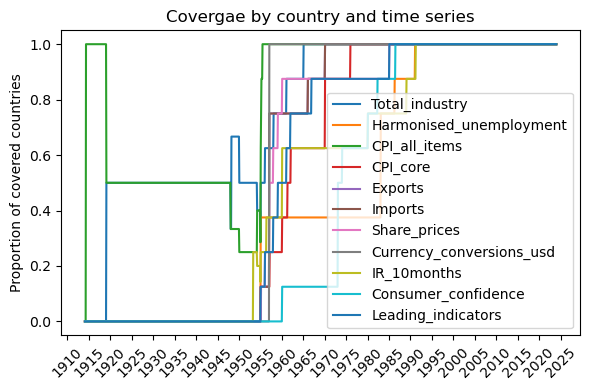

In [4]:
from mei.config_data import DATA_MEI
core_list = ["Leading_indicators", "Total_industry",
            "CPI_all_items", "Harmonised_unemployment", "CPI_core",
             "Exports", "Imports", "Share_prices",
             "IR_10months", "Consumer_confidence",
             "Currency_conversions_usd"]
panel_core = panel[core_list + ["country", "date"]].copy()
panel_core = panel_core[panel_core["country"].isin(["USA", "CAN", "GBR", "FRA", "DEU", "ITA", "ESP", "JPN"])]


fig, ax = plt.subplots(figsize=(6, 4))

for series in DATA_MEI.keys():
    if series in panel_core.columns:
        df_av = availability_over_time_series(panel_core, series)
        df_av["date_dt"] = pd.to_datetime(df_av["date"])
        ax.plot(df_av["date_dt"], df_av["availability"], label=series)

ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.ylabel("Proportion of covered countries")
plt.title("Covergae by country and time series")
plt.legend()
plt.tight_layout()
plt.show()


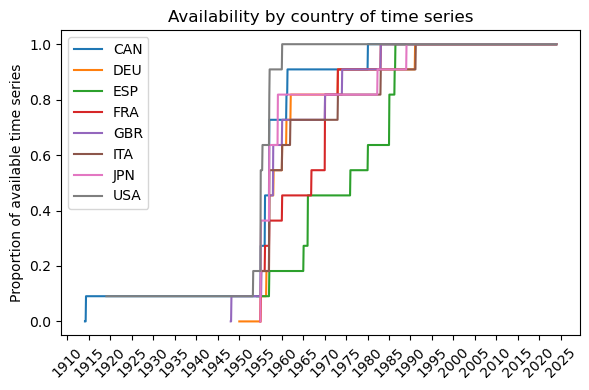

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))

                        
for country in panel_core["country"].unique():
    df_av = availability_over_time_country(panel_core, country)
    df_av["date_dt"] = pd.to_datetime(df_av["date"])
    ax.plot(df_av["date_dt"], df_av["availability"], label=country)

ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.ylabel("Proportion of available time series")
plt.title("Availability by country of time series")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
panel_core_clean = panel_core.dropna()
counts = panel_core_clean.groupby("country").size()
panel_core_clean = panel_core_clean[panel_core_clean["date"] >= "1980-01-01"]
panel_core_clean.to_csv("mei/core_macro.csv", index=False)
print(counts)
print(f"Total points: {len(panel_core_clean)}")

country
CAN    471
DEU    314
ESP    447
FRA    467
GBR    410
ITA    348
JPN    328
USA    664
dtype: int64
Total points: 3283


# Comparing Models: MSE one month ahead between 2013 and 2019

In [7]:
import pandas as pd
import numpy as np
panel = pd.read_csv("mei/core_macro.csv")
panel.set_index('date', inplace=True)
panel.index = pd.to_datetime(panel.index)
panel.drop("Currency_conversions_usd", axis=1, inplace=True)

from dataloader import MacroDataLoader

col = ["Total_industry", "CPI_all_items", "Harmonised_unemployment", "CPI_core",
        "Exports", "Imports", "Share_prices",
        "IR_10months", "Consumer_confidence"]
cfg = {
    'date_col': 'date',
    'country_col': 'country',
    'target_col': col,
    'features': col
}
loader = MacroDataLoader(panel, cfg)

from model import *
import numpy as np

models_dict = {
    'RNN': make_builder(RNNModel, config_rnn, weight_decay=1e-3),
    'NODE': make_builder(RNNModel, config_node, weight_decay=1e-3),
    'ESN': build_esn_panel,
    'RF': build_rf_panel,
    'OLS-VAR': build_var,
    'Minnesota-VAR': build_minnesota_ridge,
    'Ridge-VAR': build_ridge_cv,
    'DFM': build_dfm
}

from evaluator import UniFreqPanelMacroEvaluator

backtest_dates = pd.date_range(start='2013-01', periods=12*6, freq='ME')

evaluator = UniFreqPanelMacroEvaluator(
    dataloader=loader,
    models_builders=models_dict,
    horizon=1,
    verbose=True,
    metric='rmse'
)

results = evaluator.run_backtesting(
    end_train_date_list=backtest_dates,
    num_exp_by_fit=12
)

evaluator.print_significance_tests(results, target_idx=None, horizon_idx=0)

for i in range(len(cfg['target_col'])):
    print(f"\n {cfg['target_col'][i]}")
    evaluator.print_significance_tests(results, target_idx=i, horizon_idx=0)

[MacroDataLoader] Initialized: 8 entities, 3283 obs, 9 features.

[Backtest] Model: RNN

[Backtest] Model: NODE

[Backtest] Model: ESN

[Backtest] Model: RF

[Backtest] Model: OLS-VAR

[Backtest] Model: Minnesota-VAR

[Backtest] Model: Ridge-VAR

[Backtest] Model: DFM


/opt/anaconda3/envs/tsEcon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



STATISTICAL SIGNIFICANCE TESTS
  Target  : All Targets (sum)
  Horizon : H1

1. FRIEDMAN TEST  (Non-parametric, multiple models)
----------------------------------------------------------------------------------------------------
Statistic : 131.3750
p-value   : 0.0000  →  ✓ Significant (α=0.05)

Mean Ranks (lower = better):
        Model  Mean Rank  Mean RMSE
         NODE   3.166667   2.432611
          RNN   3.513889   2.436499
    Ridge-VAR   3.652778   2.442657
           RF   3.833333   2.454625
Minnesota-VAR   4.444444   2.515450
          ESN   4.722222   2.531012
      OLS-VAR   5.972222   2.622765
          DFM   6.694444   2.674605


2. DIEBOLD-MARIANO PAIRWISE TESTS
----------------------------------------------------------------------------------------------------
      Model 1       Model 2 Horizon  RMSE M1  RMSE M2  DM Statistic      p-value Significant        Winner
         NODE           DFM      H1 2.473918 2.724941     -8.941541 0.000000e+00         Yes          NO

In [8]:
import pandas as pd
import numpy as np
panel = pd.read_csv("mei/core_macro.csv")
panel.set_index('date', inplace=True)
panel.index = pd.to_datetime(panel.index)
panel.drop("Currency_conversions_usd", axis=1, inplace=True)

from dataloader import MacroDataLoader

col = ["Total_industry", "CPI_all_items", "Harmonised_unemployment", "CPI_core",
        "Exports", "Imports", "Share_prices",
        "IR_10months", "Consumer_confidence"]
cfg = {
    'date_col': 'date',
    'country_col': 'country',
    'target_col': col,
    'features': col
}
loader = MacroDataLoader(panel, cfg)

from model import *
import numpy as np

models_dict = {
    'RNN': make_builder(RNNModel, config_rnn, weight_decay=1e-3),
    'NODE': make_builder(RNNModel, config_node, weight_decay=1e-3),
    'ESN': build_esn_panel,
    'RF': build_rf_panel,
    'OLS-VAR': build_var,
    'Minnesota-VAR': build_minnesota_ridge,
    'Ridge-VAR': build_ridge_cv,
    'DFM': build_dfm
}

from evaluator import UniFreqPanelMacroEvaluator

backtest_dates = pd.date_range(start='2020-01', periods=22, freq='ME')

evaluator_crisis = UniFreqPanelMacroEvaluator(
    dataloader=loader,
    models_builders=models_dict,
    horizon=1,
    verbose=True,
    metric='rmse'
)

results_crisis = evaluator_crisis.run_backtesting(
    end_train_date_list=backtest_dates,
    num_exp_by_fit=6
)

evaluator_crisis.print_significance_tests(results_crisis, target_idx=None, horizon_idx=0)

for i in range(len(cfg['target_col'])):
    print(f"\n {cfg['target_col'][i]}")
    evaluator_crisis.print_significance_tests(results_crisis, target_idx=i, horizon_idx=0)

[MacroDataLoader] Initialized: 8 entities, 3283 obs, 9 features.

[Backtest] Model: RNN

[Backtest] Model: NODE

[Backtest] Model: ESN

[Backtest] Model: RF

[Backtest] Model: OLS-VAR

[Backtest] Model: Minnesota-VAR

[Backtest] Model: Ridge-VAR

[Backtest] Model: DFM


/opt/anaconda3/envs/tsEcon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



STATISTICAL SIGNIFICANCE TESTS
  Target  : All Targets (sum)
  Horizon : H1

1. FRIEDMAN TEST  (Non-parametric, multiple models)
----------------------------------------------------------------------------------------------------
Statistic : 17.2273
p-value   : 0.0160  →  ✓ Significant (α=0.05)

Mean Ranks (lower = better):
        Model  Mean Rank  Mean RMSE
          ESN   3.272727   5.485153
         NODE   3.636364   5.454938
Minnesota-VAR   4.000000   5.603564
          RNN   4.590909   5.539815
    Ridge-VAR   4.727273   5.658313
           RF   4.909091   5.703953
          DFM   5.090909   5.737028
      OLS-VAR   5.772727   5.781711


2. DIEBOLD-MARIANO PAIRWISE TESTS
----------------------------------------------------------------------------------------------------
      Model 1       Model 2 Horizon  RMSE M1  RMSE M2  DM Statistic  p-value Significant        Winner
          ESN     Ridge-VAR      H1 8.010554 8.153323     -2.742566 0.006096         Yes           ESN
      